<a href="https://colab.research.google.com/github/shivabalan1712/colab/blob/main/Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
landlord_handwriting_recognition_path = kagglehub.dataset_download('landlord/handwriting-recognition')

print('Data source import complete.')


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import keras
import keras.layers as L
import keras.models as M
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from keras.utils import Sequence

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivxk","key":"380ec4e99cbd6e562818a33c2603e474"}'}

In [4]:
import os
import shutil

# Create a hidden .kaggle folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to that folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!pip install -q kaggle
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip -d handwriting_dataset


Streaming output truncated to the last 5000 lines.
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5003.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5004.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5005.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5006.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5007.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5008.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5009.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5010.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5011.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5012.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_5013.jpg  
  inflating: handwriting_dataset/validation_v2/validation/VALIDATION_

In [6]:
train=pd.read_csv('/content/handwriting_dataset/written_name_train_v2.csv')
validation=pd.read_csv('/content/handwriting_dataset/written_name_validation_v2.csv')

In [7]:
train.dropna(inplace=True)

In [8]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [9]:
train[train['IDENTITY']=='zucchi']

,FILENAME,IDENTITY
20507,TRAIN_20508.jpg,zucchi


In [10]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

<ipython-input-10-955a0cf30fa1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IDENTITY']=train['IDENTITY'].str.upper()


,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [11]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)

In [12]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)

In [13]:
# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [14]:
path_train='/content/handwriting_dataset/train_v2/train'
path_validation='/content/handwriting_dataset/validation_v2/validation'

In [15]:
# Data Generator
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe)//self.batch_size

    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text:
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length

            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)


In [16]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

In [17]:
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras import backend as K

class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost  # TensorFlow backend version

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss


In [18]:
# Making the Model now
def make_model():
    inp=L.Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=L.Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=L.Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=L.Input(shape=[1],dtype=np.int64,name='label_length')
    x=L.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    x=L.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=L.Reshape(new_shape)(x)
    x=L.Dense(64,activation='relu')(x)
    x=L.Dropout(0.2)(x)
    x=L.Bidirectional(L.LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=L.Bidirectional(L.LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=L.Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    model=M.Model([inp,labels,input_length,label_length],output)
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    model.compile(optimizer=sgd)
    return model

In [19]:
model=make_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 64,   │        640 │ input_data[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 32,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 32,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 32,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 2048)  │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 64)    │    131,136 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64, 256)   │    197,632 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_label         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_output        │ (None, 64, 31)    │      3,999 │ bidirectional_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (CTCLayer)  │ (None, 1)         │          0 │ input_label[0][0… │
│                     │                   │            │ Dense_output[0][… │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][

 Total params: 571,615 (2.18 MB)

 Trainable params: 571,615 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    history = model.fit(train_generator,steps_per_epoch=1000,validation_data=validation_generator,
                        epochs=8)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 236s 227ms/step - loss: 3264.8362 - val_loss: 2353.8115
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 215s 215ms/step - loss: 2304.8604 - val_loss: 2028.4647
Epoch 3/8
  64/1000 ━━━━━━━━━━━━━━━━━━━━ 3:20 214ms/step - loss: 2095.9285

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2080.6084 - val_loss: 2008.2002
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 254s 215ms/step - loss: 1968.0464 - val_loss: 1519.6874
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 214s 214ms/step - loss: 1445.1494 - val_loss: 903.9105
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 1035.3593 - val_loss: 879.3808
Epoch 7/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 215s 215ms/step - loss: 915.0067 - val_loss: 625.4714
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 214s 214ms/step - loss: 692.6329 - val_loss: 493.4349


In [23]:
prediction_model = keras.models.Model(model.input[0], model.get_layer('Dense_output').output)

prediction_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)         │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 64, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 64)         │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_output (Dense)            │ (None, 64, 31)         │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,615 (2.18 MB)

 Trainable params: 571,615 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.h5')
    prediction_model=M.load_model('prediction_model_ocr.h5')

In [25]:
label_to_char[100]=''

In [26]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
Ground truth: LEFORT 	 Predicted: LEFORT
Ground truth: MATHILDE 	 Predicted: MATHILDE
Ground truth: ILONA 	 Predicted: ILOMA
Ground truth: BELLIN 	 Predicted: BELLIN
Ground truth: DUFFAU 	 Predicted: OUFFAU
Ground truth: HAJ RHOUMA 	 Predicted: MAS AHOUMA
Ground truth: BONNIN 	 Predicted: JOMMIN
Ground truth: FAURE 	 Predicted: FAURE
Ground truth: HAMMOUR 	 Predicted: AMNOUA
Ground truth: ETIENNE 	 Predicted: ETIENNE
Ground truth: GOHAR 	 Predicted: GOMAR
Ground truth: DOYURUR 	 Predicted: DOYUEUE
Ground truth: HORRENOR 	 Predicted: MOTHINOT
Ground truth: CHARPENTIER 	 Predicted: CHARPENTIER
Ground truth: MATHILDE 	 Predicted: MATHILDE
Ground truth: CARLA 	 Predicted: CARLA
Ground truth: RYCKELYNCK 	 Predicted: ALCHELYNER
Ground truth: LAIGNEAU 	 Predicted: LAIGNEAU
Ground truth: INES 	 Predicted: INES
Ground truth: YOUNES 	 Predicted: YOUNES
Ground truth: THEO 	 Predicted: THEO
Ground truth: NOLWENN 	 Predicted: NOLHENN
Ground truth: ANANDINE 	 P

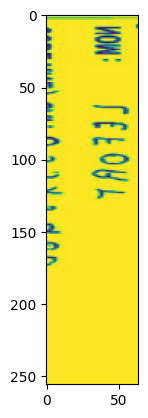

In [27]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    plt.imshow(X_data[0])
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)

    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Text: JULES


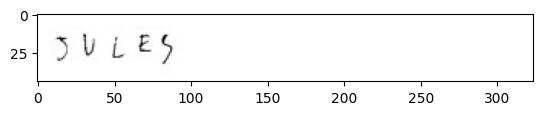

In [31]:
batch_images=np.ones((128,256,64,1),dtype=np.float32)
img=cv2.imread('/content/handwriting_dataset/test_v2/test/TEST_0004.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=cv2.resize(img,(256,64))
img=(img/255).astype(np.float32)
img=img.T
img=np.expand_dims(img,axis=-1)
batch_images[0]=img
x=prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(x)
pred_texts = pred_texts[0]
im=cv2.imread('/content/handwriting_dataset/test_v2/test/TEST_0004.jpg')
plt.imshow(im)
print('Predicted Text:',pred_texts)